<a href="https://colab.research.google.com/github/sajeelahmed34/Articles-Recognition-Using-Deep-Neural-Network/blob/main/mnist_fashion_data_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of products using Fashion MNIST Dataset 

Fashion-mnist is a dataset of Zalando's article images. It consists of a 60,000 training images and a test set of 10,000 images. Each image is a 28x28 grayscale image, associated with a label from 10 classes. In the following we will build a deep learning model which can classify different fashion products into their respective classes. 

To start with, first we need to import te tensorflow library and set the version to 2.0

In [ ]:
# importing tensorflow lib
import tensorflow as tf

# changing the version of tensorflow to 2.0
%tensorflow_version 2.x
print(tf.version)

In [ ]:
# importing helper libraries 
import numpy as np 
import matplotlib.pyplot as plt 

# Import dataset
For this self project we will use a MNIST Fasion dataset. This is the dataset that is inclused in keras and this dataset contains 60,000 images for training and 10,000 images for validating/testing the model.

In [ ]:
from tensorflow import keras

fashion_mnist = keras.datasets.fashion_mnist # loading dataset 
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data() # getting tuples of training and testing data

In [ ]:
# we can look at the size of the train and test data 
print('train images: ', train_images.shape)
print('test images: ', test_images.shape)

train images:  (60000, 28, 28)
test images:  (10000, 28, 28)


The training dataset contains 60,000 images and each image consists of 28x28 pixels. Similarly the test dataset contains 10,000 images and each image consists of 28x28 pixels. 

We can look at some of the images to see what clothe articles we are having in our dataset 

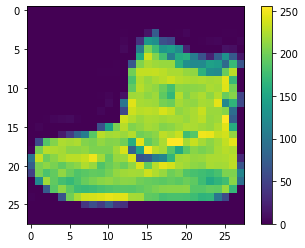

In [ ]:
plt.figure()
plt.imshow(train_images[0]) # display first image on a 2D regular raster 
plt.colorbar()
plt.show()

The above image probably looks like a sneaker. lets check other ones

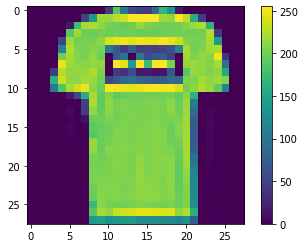

In [ ]:
plt.figure()
plt.imshow(train_images[1]) # display first image on a 2D regular raster 
plt.colorbar()
plt.show()

It looks like a T-shirt 

# Preprocessing data 
We are having grayscale images and the pixel values ranges from 0 to 255. What we can do is to preprocess our data before feeding it to our model. We will transform each pixel value in the range of 0 to 1 by diving it by 255.0.We do this because smaller values will make it easier for the model to process our values.

In [ ]:
train_images = train_images.astype('float32')/255.0
test_images = test_images.astype('float32')/255.0

# Building the Model

Lets use a simple keras sequential model with three different layers.

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28))) # input layer 
model.add(keras.layers.Dense(128, activation='relu')) # hiddel layer
model.add(keras.layers.Dense(10, activation='softmax')) # output layer 

# Compiling the Model

In [ ]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Training the Model

In [ ]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.4954 - accuracy: 0.8249
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3759 - accuracy: 0.8634
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3380 - accuracy: 0.8766
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3130 - accuracy: 0.8857
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2942 - accuracy: 0.8905
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2795 - accuracy: 0.8970
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2690 - accuracy: 0.8997
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2577 - accuracy: 0.9034
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2483 - accuracy: 0.9072
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.239

# Evaluating the Model

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)
print('Test accuracy:', test_acc)

313/313 [==============================] - 1s 1ms/step - loss: 0.3472 - accuracy: 0.8786
Test accuracy: 0.878600001335144


The test accuracy is 85.45% which is less than the training accuracy (87.72%). This is due to the **overfitting**. We can avoid this overfitting by choosing less value for the epochs. **epochs** indicates how many times our model will see the entire dataset. Choosing higher value for epochs indicating that our model is seeing dataset so many times that actually it has memorize the training data and will not generalize well on the test data. 

# Hyperparameter Tuning 

Another important thing to notice that we have randomly choosen the hyperparameters. In this network we are having many hyperparameters such as **number of hidden neurons**, **optimizers**, **learning rate** 

We can choose the best hyperparameters with the help of a **keras tuner**

In [ ]:
# install and import the keras tuner 
!pip install -q -U keras-tuner

import keras_tuner as kt 

# Re-build the Model

In [ ]:
# we can use the model builder function to define the image classification model 
def model_builder(hp):
  model = keras.Sequential() # choose sequential model
  model.add(keras.layers.Flatten(input_shape=(28, 28))) # input layer 

  # tune the number of neurons in the first hidden layer 
  hp_units = hp.Int(name='units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu')) # hidden layer 

  model.add(keras.layers.Dense(10)) # output layer 

  # tune the learning rate for the optimizer
  hp_learning_rate = hp.Choice(name='learning_rate', values=[0.01, 0.001, 0.0001])

  # compile the model 
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                metrics=['accuracy'])

  return model

# Instantiate the tuner and performing hyperparamter tuning 

There are four different hyperparameter tunning methods including `RandomSearch`, `Hyperband`, `BayessianOptimization` and `sklearn`

Lets try `Hyperband` technique

In [ ]:
tuner = kt.Hyperband(model_builder, 
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     overwrite=True,
                     directory='hyperband', 
                     project_name='fasion_mnist')

In [ ]:
# we can avoid overfitting by early stopping that means stops training as the validation loss begins rissing again 
# we can creat a callback for this
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5) 

In [ ]:
# run the hyperparameter searching 
tuner.search(train_images, train_labels, epochs=50, validation_split=0.2, callbacks=[stop_early])

# get the optimal hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 00m 53s]
val_accuracy: 0.8645833134651184

Best val_accuracy So Far: 0.8910833597183228
Total elapsed time: 00h 14m 35s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# printing the best combination of hypermeters 
print('The optimal number of neurons in the first densly connected hidden layer is {} \nThe optimal value for the learning rate is {}'.format(best_hp.get('units'), best_hp.get('learning_rate')))

The optimal number of neurons in the first densly connected hidden layer is 416 
The optimal value for the learning rate is 0.001


# Re-train the Model

In [ ]:
# build the model with the optimal hyperparamters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hp)
history = model.fit(train_images, train_labels, validation_split=0.2, epochs=50)

Epoch 1/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.4969 - accuracy: 0.8231 - val_loss: 0.3925 - val_accuracy: 0.8594
Epoch 2/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3719 - accuracy: 0.8646 - val_loss: 0.3852 - val_accuracy: 0.8604
Epoch 3/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3324 - accuracy: 0.8777 - val_loss: 0.3590 - val_accuracy: 0.8725
Epoch 4/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3073 - accuracy: 0.8869 - val_loss: 0.3292 - val_accuracy: 0.8832
Epoch 5/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2843 - accuracy: 0.8949 - val_loss: 0.3342 - val_accuracy: 0.8827
Epoch 6/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2730 - accuracy: 0.8988 - val_loss: 0.3559 - val_accuracy: 0.8768
Epoch 7/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2579 - accuracy: 0.9036 - val_loss: 0.3128 - val_accuracy:

In [ ]:
# now we can select the best epoch which gives us the smallest validation loss 
val_accuracy_per_epoch = history.history['val_accuracy']
best_epoch = val_accuracy_per_epoch.index(max(val_accuracy_per_epoch))+1
print('best epoch: ', best_epoch)

best epoch:  35


Re-instantiate the hypermodel and train the model with the best hyperparameters 

In [ ]:
hypermodel = tuner.hypermodel.build(best_hp)

# re-train the model
hypermodel.fit(train_images, train_labels, epochs=best_epoch, validation_split=0.2)

Epoch 1/35
1500/1500 [==============================] - 7s 5ms/step - loss: 0.4959 - accuracy: 0.8243 - val_loss: 0.4030 - val_accuracy: 0.8553
Epoch 2/35
1500/1500 [==============================] - 7s 4ms/step - loss: 0.3713 - accuracy: 0.8653 - val_loss: 0.3495 - val_accuracy: 0.8691
Epoch 3/35
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3342 - accuracy: 0.8763 - val_loss: 0.3530 - val_accuracy: 0.8714
Epoch 4/35
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3074 - accuracy: 0.8865 - val_loss: 0.3349 - val_accuracy: 0.8758
Epoch 5/35
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2881 - accuracy: 0.8913 - val_loss: 0.3213 - val_accuracy: 0.8845
Epoch 6/35
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2730 - accuracy: 0.8986 - val_loss: 0.3236 - val_accuracy: 0.8821
Epoch 7/35
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2569 - accuracy: 0.9040 - val_loss: 0.3184 - val_accuracy:

# Re-evaluating the Model

In [ ]:
eval_result = hypermodel.evaluate(test_images, test_labels)

print('[test loss, test_accuracy]= ', eval_result)

313/313 [==============================] - 1s 3ms/step - loss: 0.5219 - accuracy: 0.8860
[test loss, test_accuracy]=  [0.5219339728355408, 0.8859999775886536]


# Prediction on test data 

Our labels are integers ranging from 0 - 9. Each integer represents a specific article of clothing. We'll create an array of label names to indicate which is which.

In [ ]:
predictions = hypermodel.predict(test_images)

# Verifying Predictions

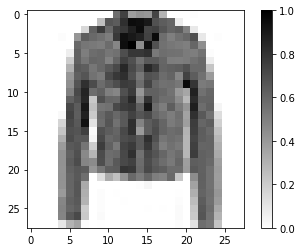

correct class:  Coat
prediced class:  Coat


In [ ]:
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR

def predict(hypermodel, image, correct_label):
  class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
  prediction = hypermodel.predict(np.array([image]))
  predicted_class = class_names[np.argmax(prediction)]

  show_image(image, class_names[correct_label], predicted_class)


def show_image(img, label, guess):
  plt.figure()
  plt.imshow(img, cmap=plt.cm.binary)
  plt.colorbar()
  plt.grid(False)
  plt.show()
  print('correct class: ', label)
  print('prediced class: ' , guess)
num = 10
image = test_images[num]
label = test_labels[num]
predict(hypermodel, image, label)


# Summary

The followwing important points to notice:

*   Developed a deep neural network classifier with three layers, the `input layer`, `1 hidden layer` and `output layer` 
*   Input layer consists of 784 neurons, output layer consists of 10 neurons this is due to the fact that we are having fashion articles from 10 different classes. 
* For hyperparameter tuning, we have used Hyperband technique although there are other methods available. 
* After hyperparameter tuning, we got 416 neurons are required for the hidden layer, it requires 35 epochs to train the model and an early stopping scheme is used to prevent model from overfitting. 
* The validation accuracy is 89.52% while the test accuracy is 88.60%

